In [29]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import shap

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set_theme(style='whitegrid')

In [30]:
# 1. Load your scraped dataset
df = pd.read_csv('../collect data/data/sri_lankan_vehicles.csv')
df.head()

,Title,Price,Mileage,Location,Date,URL,DetailURL,AdTitle,PostedBy,PostedOn,...,YOM,MileageKM,Gear,FuelType,Options,EngineCC,Details,ContactDigits,Views,ViewsRaw
0,Suzuki Swift 2005 Car,"Rs. 4,250,000",131000 (km),Colombo,2026-02-20,https://riyasewana.com/buy/suzuki-swift-sale-c...,https://riyasewana.com/buy/suzuki-swift-sale-c...,Suzuki Swift 2005 Car (Used),Dushmantha Dissanayake,2026-02-20,...,2005,131000,Manual,Petrol,"AIR CONDITION, POWER STEERING, POWER MIRROR, P...",1300,Suzuki Swift (Center Antenna) Jeep Model for S...,777925157,456,456 Views
1,MG MG4 2024 Car,"Rs. 12,500,000",15000 (km),Gampaha,2026-02-18,https://riyasewana.com/buy/mg-mg4-sale-gampaha...,https://riyasewana.com/buy/mg-mg4-sale-gampaha...,MG MG4 2024 Car (Used),Chandana Wijayathilake,2026-02-18,...,2024,15000,Automatic,Electric,"AIR CONDITION, POWER STEERING, POWER MIRROR, P...",125,🌟 MG4 EV 2024 | Signature Electric Performance...,711904052,1019,1019 Views
2,Audi A3 Sedan TFSI 2023 Car,"Rs. 15,900,000",16000 (km),Colombo,2026-02-20,https://riyasewana.com/buy/audi-a3-sedan-sale-...,https://riyasewana.com/buy/audi-a3-sedan-sale-...,Audi A3 Sedan TFSI 2023 Car Unregistered (Reco...,Assidua Automobiles (Pvt) Ltd,2026-02-20,...,2023,16000,Automatic,Petrol,"AIR CONDITION, POWER STEERING, POWER MIRROR, P...",1000,Audi A3 Sedan TFSI (2023) — Black (Exterior & ...,776731758,141,141 Views
3,Toyota Aqua X Urban 2015 Car,"Rs. 8,550,000",108000 (km),Wennappuwa,2026-02-20,https://riyasewana.com/buy/toyota-aqua-x-sale-...,https://riyasewana.com/buy/toyota-aqua-x-sale-...,Toyota Aqua X Urban 2015 Car (Used),Ranish Nirmal,2026-02-20,...,2015,108000,Automatic,Hybrid,"AIR CONDITION, POWER STEERING, POWER MIRROR, P...",1500,AQUA X urban 2015\nYOM 2015\n108000km\nA to Z ...,778404182,595,595 Views
4,BMW 520d 2015 Car,"Rs. 28,500,000",119000 (km),Gampaha,2026-02-21,https://riyasewana.com/buy/bmw-520d-sale-gampa...,https://riyasewana.com/buy/bmw-520d-sale-gampa...,BMW 520d 2015 Car (Used),Nuwan Senaka,2026-02-21,...,2015,119000,Automatic,Diesel,"AIR CONDITION, POWER STEERING, POWER MIRROR, P...",1995,Registered Owner\nApple Player (4 way Camera)\...,773735489,1,1 Views


In [31]:
# 2. Clean the Price column (Remove 'Rs.', commas, and spaces)
df['Price_Clean'] = df['Price'].astype(str).str.replace('Rs.', '', regex=False).str.replace(',', '').str.strip()
df['Price_Clean'] = pd.to_numeric(df['Price_Clean'], errors='coerce')

# 3. Ensure Mileage is numeric
df['MileageKM_Clean'] = pd.to_numeric(df['MileageKM'], errors='coerce')

# 4. Feature Engineering from the seller description
details_lower = df['Details'].astype(str).str.lower()
df['is_first_owner'] = details_lower.str.contains('1st owner|first owner').astype(int)
df['is_accident_free'] = details_lower.str.contains('accident free|no accident|100% accident').astype(int)
df['is_mint_condition'] = details_lower.str.contains('mint condition|superb condition|excellent condition|showroom condition').astype(int)
df['has_service_records'] = details_lower.str.contains('service records|maintenance records|records available').astype(int)

# 5. Select only the columns used by the model
ml_columns = [
    'Make', 'Model', 'YOM', 'MileageKM_Clean', 'Gear', 'FuelType', 'EngineCC',
    'is_first_owner', 'is_accident_free', 'is_mint_condition', 'has_service_records',
    'Price_Clean',
]

df_ml_ready = df[ml_columns].dropna(subset=['Price_Clean']).copy()

# --- Filter invalid/wrong Model values so they don't enter the final dataset ---
df_ml_ready['Make'] = (
    df_ml_ready['Make']
    .astype(str)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)
df_ml_ready['Model'] = (
    df_ml_ready['Model']
    .astype(str)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

make_key = df_ml_ready['Make'].str.casefold()
model_key = df_ml_ready['Model'].str.casefold()

placeholder_models = model_key.isin({'', 'nan', 'none', 'n/a', 'na', 'null', '-', '--', 'unknown'})
model_equals_make = model_key == make_key
model_contains_year = model_key.str.contains(r'\b(?:19\d{2}|20\d{2})\b', regex=True, na=False)

# If the "Model" field contains ad-like tokens, it's likely parsed wrong (keep this conservative)
ad_like_tokens = model_key.str.contains(r'\bkm\b|lkr|\bprice\b|negotiable|contact|call|rs\.', regex=True, na=False)

invalid_model_mask = placeholder_models | model_equals_make | model_contains_year | ad_like_tokens
removed_invalid_models = int(invalid_model_mask.sum())
if removed_invalid_models:
    print(f'Removed rows with invalid Model values: {removed_invalid_models}')
    print('Sample removed (Make, Model):')
    print(df_ml_ready.loc[invalid_model_mask, ['Make', 'Model']].head(10).to_string(index=False))
    df_ml_ready = df_ml_ready.loc[~invalid_model_mask].copy()
else:
    print('Removed rows with invalid Model values: 0')

# --- Normalize casing so case-only duplicates don't appear as separate models ---
def _mode_string(values: pd.Series) -> str:
    vc = values.astype(str).value_counts()
    return str(vc.index[0]) if len(vc) else ''

# Normalize Make casing (e.g., TOYOTA vs Toyota)
make_key = df_ml_ready['Make'].str.casefold()
df_ml_ready['Make'] = df_ml_ready.groupby(make_key)['Make'].transform(_mode_string)

# Normalize Model casing within each Make (e.g., AXio vs AXIO)
pair_key = df_ml_ready['Make'].str.casefold() + '||' + df_ml_ready['Model'].str.casefold()
df_ml_ready['Model'] = df_ml_ready.groupby(pair_key)['Model'].transform(_mode_string)

# Numeric parsing after text cleanup
df_ml_ready['YOM'] = pd.to_numeric(df_ml_ready['YOM'], errors='coerce')
df_ml_ready['EngineCC'] = pd.to_numeric(df_ml_ready['EngineCC'], errors='coerce')

data_dir = Path('../data')
data_dir.mkdir(parents=True, exist_ok=True)
df_ml_ready.to_csv(data_dir / 'ml_ready_vehicles.csv', index=False)

print(f'Rows after initial cleaning: {len(df_ml_ready)}')
df_ml_ready.head()

Removed rows with invalid Model values: 12
Sample removed (Make, Model):
      Make      Model
Mitsubishi Mitsubishi
 Chevrolet  CHEVROLET
    Nissan     Nissan
    Nissan     Nissan
    Nissan     Nissan
     Honda      Honda
  Daihatsu   Daihatsu
   Renault    Renault
    Toyota     Toyota
        MG         MG
Rows after initial cleaning: 3986


,Make,Model,YOM,MileageKM_Clean,Gear,FuelType,EngineCC,is_first_owner,is_accident_free,is_mint_condition,has_service_records,Price_Clean
0,Suzuki,Swift,2005,131000.0,Manual,Petrol,1300.0,0,0,0,0,4250000.0
1,MG,MG4,2024,15000.0,Automatic,Electric,125.0,0,0,1,0,12500000.0
2,Audi,A3 Sedan TFSI,2023,16000.0,Automatic,Petrol,1000.0,0,0,0,0,15900000.0
3,Toyota,Aqua X Urban,2015,108000.0,Automatic,Hybrid,1500.0,0,1,0,1,8550000.0
4,BMW,520D,2015,119000.0,Automatic,Diesel,1995.0,0,0,1,0,28500000.0


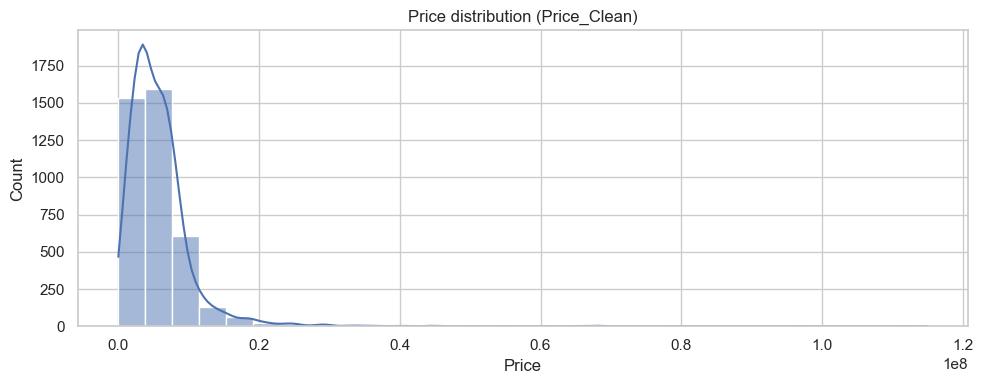

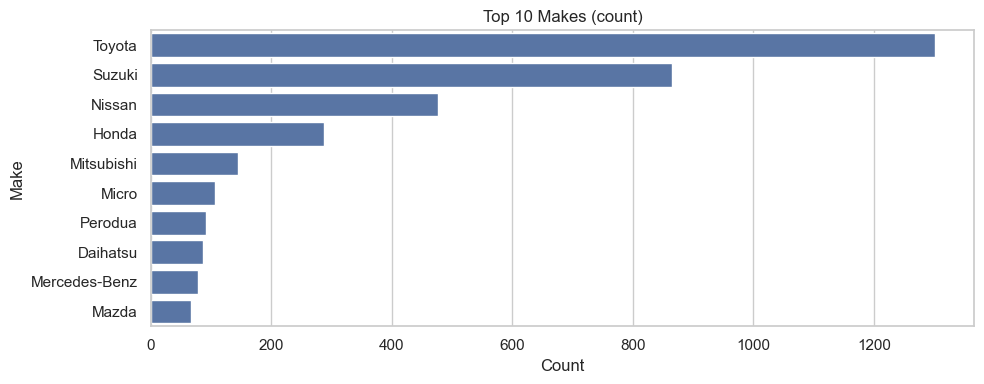

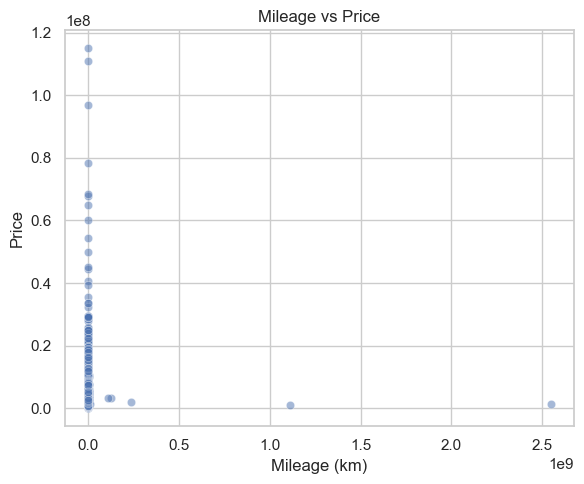

In [32]:
# EDA: quick tables + plots (after initial cleaning)

# Table 1: missing values in ML columns
missing_table = (
    df_ml_ready.isna()
    .sum()
    .sort_values(ascending=False)
    .to_frame('missing_count')
 )
missing_table['missing_pct'] = (missing_table['missing_count'] / len(df_ml_ready) * 100).round(2)
missing_table

# Table 2: summary stats for numeric columns
df_ml_ready[['Price_Clean', 'MileageKM_Clean', 'YOM', 'EngineCC']].describe().T

# Plot 1: distribution of target price
plt.figure(figsize=(10, 4))
sns.histplot(df_ml_ready['Price_Clean'].dropna(), bins=30, kde=True)
plt.title('Price distribution (Price_Clean)')
plt.xlabel('Price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot 2: top makes count
top_makes = df_ml_ready['Make'].value_counts().head(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_makes.values, y=top_makes.index)
plt.title('Top 10 Makes (count)')
plt.xlabel('Count')
plt.ylabel('Make')
plt.tight_layout()
plt.show()

# Plot 3: mileage vs price (scatter)
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_ml_ready, x='MileageKM_Clean', y='Price_Clean', alpha=0.5)
plt.title('Mileage vs Price')
plt.xlabel('Mileage (km)')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [33]:
# 6. Handle Outliers using IQR (Interquartile Range)
def remove_outliers(data: pd.DataFrame, col: str) -> pd.DataFrame:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

In [34]:
df_clean = remove_outliers(df_ml_ready, 'Price_Clean')
df_clean = remove_outliers(df_clean, 'MileageKM_Clean')
df_clean = df_clean.copy()
print(f'Dataset size after outlier removal: {len(df_clean)}')

Dataset size after outlier removal: 3461


In [35]:
# 7. Preprocessing for XGBoost (train/test-safe)
target_col = 'Price_Clean'

X = df_clean.drop(columns=[target_col]).copy()
y = df_clean[target_col].copy()

categorical_features = ['Make', 'Model', 'Gear', 'FuelType']
numeric_features = [c for c in X.columns if c not in categorical_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))
        ,('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop',
)

X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = preprocess.transform(X_test)

# Save artifacts to the parent folder's model/ directory (../model)
model_dir = Path('../model')
model_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(preprocess, model_dir / 'preprocess_ohe.pkl')

X_train_processed.shape, X_test_processed.shape

((2768, 963), (693, 963))

In [36]:
# 8. Train an XGBoost model (baseline)
try:
    from xgboost import XGBRegressor
except ImportError as e:
    raise ImportError('xgboost is not installed. Install it with: pip install xgboost') from e

xgb_model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
 )

xgb_model.fit(X_train_processed, y_train)
pred = xgb_model.predict(X_test_processed)
rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
mae = float(mean_absolute_error(y_test, pred))

joblib.dump(xgb_model, model_dir / 'xgb_model.pkl')
{'rmse': rmse, 'mae': mae, 'train_rows': int(len(y_train)), 'test_rows': int(len(y_test))}

{'rmse': 1124466.1187238293,
 'mae': 592470.8252164503,
 'train_rows': 2768,
 'test_rows': 693}

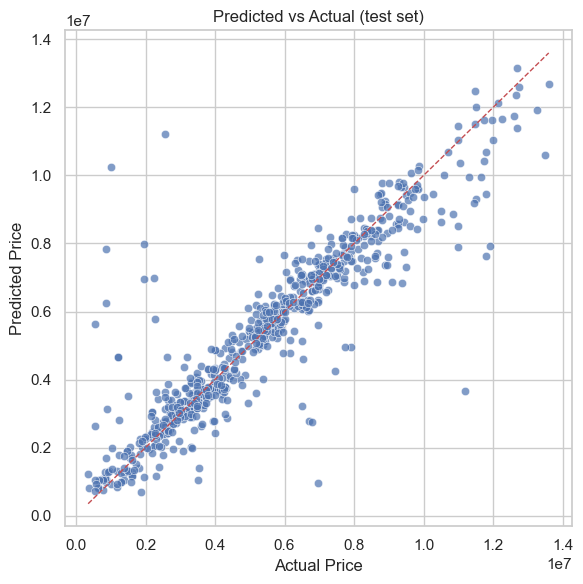

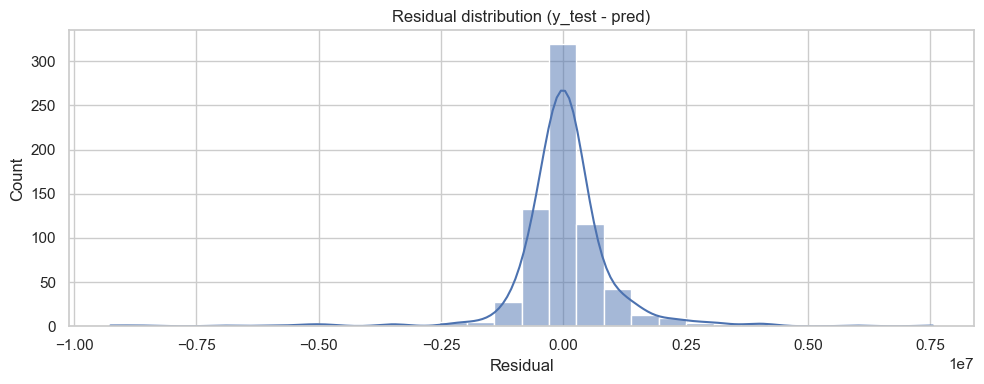

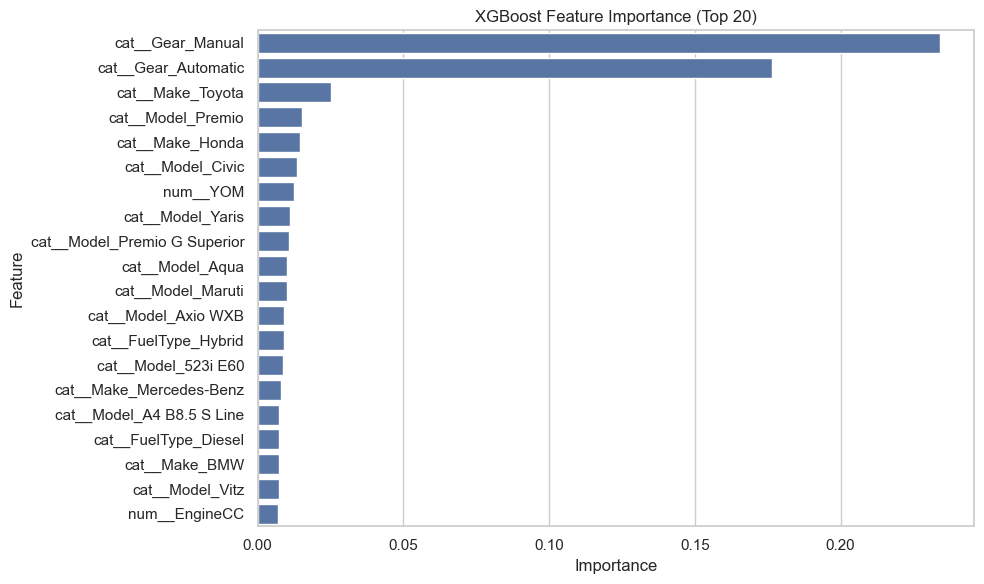

In [37]:
# Model diagnostics: plots (after training)

# Plot 4: predicted vs actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=pred, alpha=0.7)
min_v = float(min(y_test.min(), pred.min()))
max_v = float(max(y_test.max(), pred.max()))
plt.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=1)
plt.title('Predicted vs Actual (test set)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.tight_layout()
plt.show()

# Plot 5: residual distribution
residuals = (y_test.values - pred)
plt.figure(figsize=(10, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residual distribution (y_test - pred)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot 6: feature importance (top 20)
try:
    feature_names = preprocess.get_feature_names_out()
except Exception:
    feature_names = np.array([f'feature_{i}' for i in range(len(xgb_model.feature_importances_))])

importances = xgb_model.feature_importances_
fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi = fi.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=fi, x='importance', y='feature')
plt.title('XGBoost Feature Importance (Top 20)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [38]:
# 1. Extract feature names from the ColumnTransformer pipeline
# Get numeric feature names
num_cols = numeric_features
# Get categorical feature names generated by the OneHotEncoder
cat_cols = preprocess.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
# Combine them in the exact order the ColumnTransformer outputs them
all_feature_names = list(num_cols) + list(cat_cols)

In [39]:
# 2. Initialize the SHAP TreeExplainer using your trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

Calculating SHAP values...


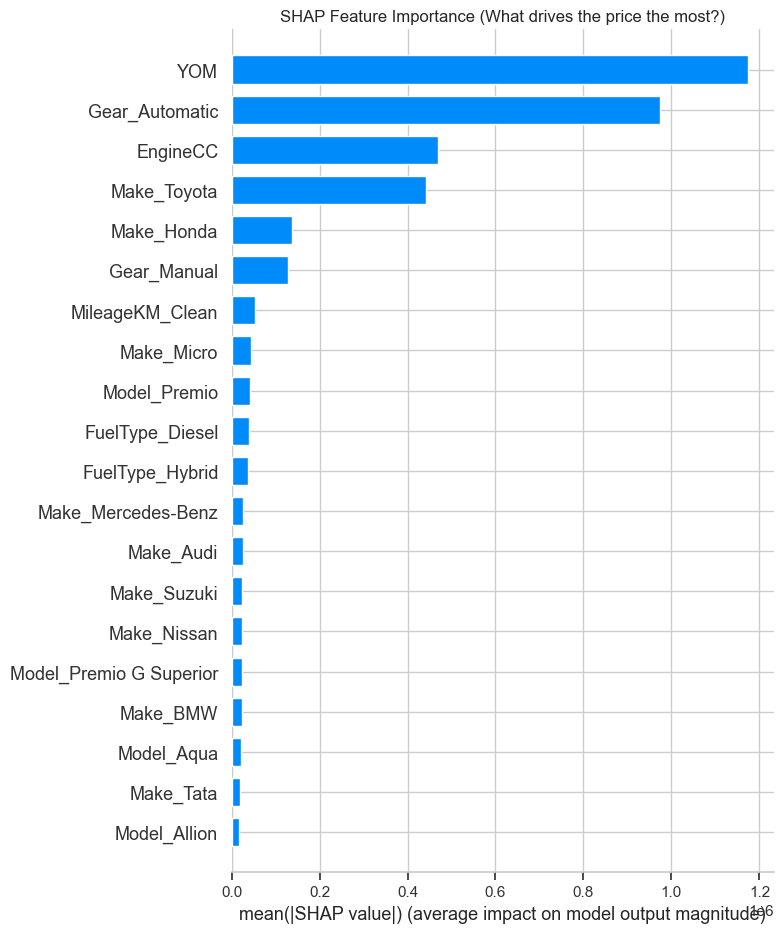

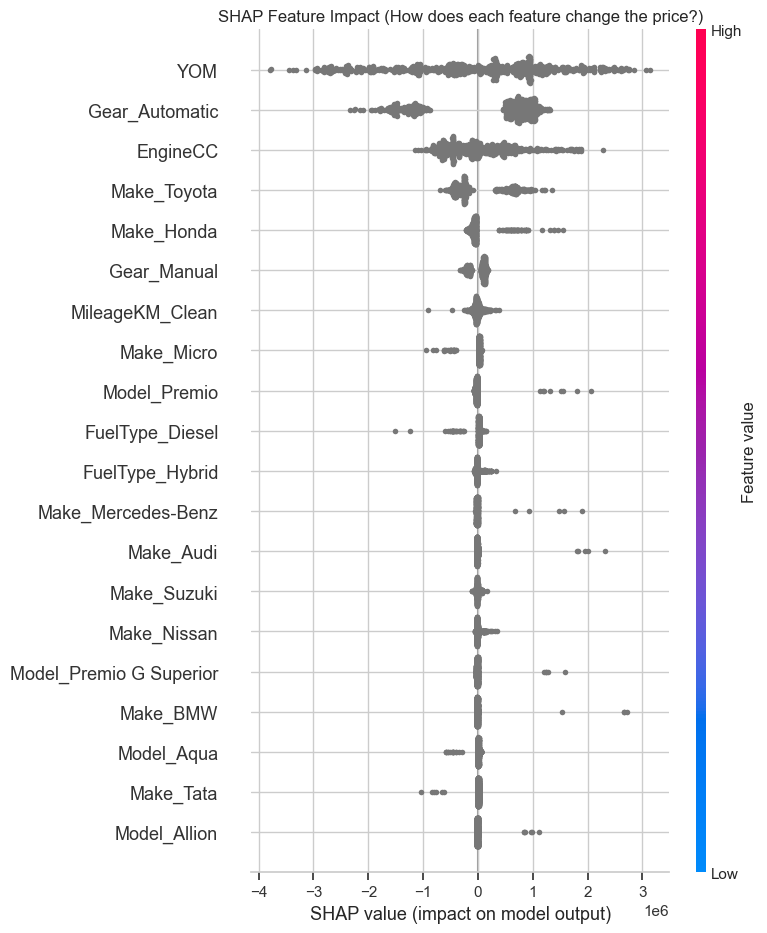

In [40]:
# 3. Calculate SHAP values for the transformed Test dataset
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test_processed)

# 4. Generate SHAP Bar Plot (Global Feature Importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_processed, feature_names=all_feature_names, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (What drives the price the most?)")
plt.tight_layout()
plt.show()

# 5. Generate SHAP Dot Plot (Directional Feature Impact)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_processed, feature_names=all_feature_names, show=False)
plt.title("SHAP Feature Impact (How does each feature change the price?)")
plt.tight_layout()
plt.show()